Additional tests and preparing pictures  

@author: Anton Erofeev

In [1]:
import numpy as np
import pandas as pd
import pickle as pk

import scipy.sparse as sparse
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, clear_output, update_display
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn


device = torch.device('cpu')

np.random.seed(1)
np.random.randint(0, 1000, 4)

array([ 37, 235, 908,  72])

In [ ]:
#upload data
with open('../trajectory/trace_LV_2_e7.pkl', 'rb') as file:
    train_data = pk.load(file)

with open('../trajectory/predict_data.pkl', 'rb') as file:
    predict_data = pk.load(file)

with open('model_LV.pkl', 'rb') as file:
    model = pk.load(file)

In [ ]:
#model global parameters
parameters = {'N': 200,     #reservoir dimension
            'dim_input': 4,   #total dim of the data
            'degree': 180,   #num connections per neuron
            'radius': 0.5,  #specral radius
            'w': 5,  #range for Win = unif[-w,w]
            'a': 0.001, #regularization
            'm1': np.array([0.30130301, 0.4586546 , 0.13076546, 0.35574161]),
            'm2': np.array([0.00613064, 0.01567845, 0.00802094, 0.00660596]),
            'm3': np.array([ 5.97923646e-04, -8.20942794e-05,  4.08964845e-04, -1.78523141e-05]),
            'm4': np.array([0.00018159, 0.00064422, 0.00017017, 0.0001261 ]),
            }
consts = {
    'left_q': 0.02,
    'right_q': 0.98,
}

warm = 100
predict_size = 10000000
training_size = 1000000
pred_batch = 400

ts = np.arange(pred_batch)

y_lim = [[2.5, 0.6], [1.3, 1.2], [20, 1.5], [1.3, 1.4]]
x_dmain = [0.01, 0.015, 0.005, 0.005]
x_dtail = [[-0.005, 0.02], [-0.01, 0.01], [-0.0007, 0.01], [-0.01, 0.01]]

lyap_ts = ts * 2 * 0.0203

In [ ]:
#model trained parameters
Win, reservoir, Wout = model

In [66]:
#synchronization test
size = 10000
N = reservoir.shape[0]

state_zero = np.zeros((size, N))
state_changed = np.zeros((size, N))
state_zero[0] = np.tanh(0 + train_data[0] @ Win)
state_changed[0] = np.tanh(1e-2 * np.random.randn(1, N) @ reservoir + train_data[0] @ Win)

for i in range(1, size):
    state_zero[i] = np.tanh(state_zero[i-1] @ reservoir + train_data[i] @ Win)
    state_changed[i] = np.tanh(state_changed[i-1] @ reservoir + train_data[i] @ Win)

norm = np.linalg.norm(state_zero - state_changed, axis=-1)


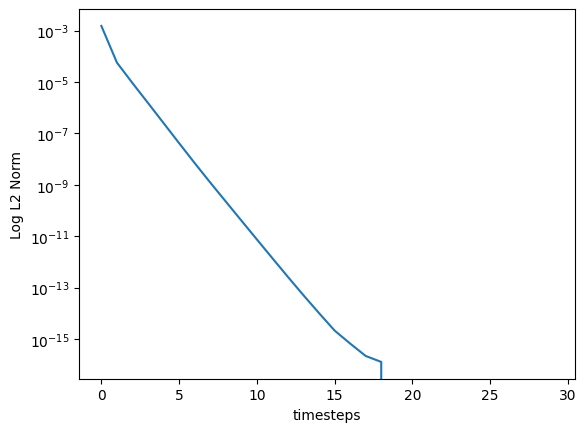

In [79]:
plt.semilogy(norm[:30])
plt.xlabel(f'timesteps')
plt.ylabel(f'Log L2 Norm')
plt.savefig(f'synch_test.png', bbox_inches='tight')


In [ ]:
#max gev test
q = 200
print(f"Max  LV   ESN   diff%")
for i in range(4):
    a = train_data[:, i]

    b = predict_data[:, i]


    max_tail_t = np.array([])
    max_tail_p = np.array([])

    for o in range(0,len(a), q):

        max_tail_t = np.append(max_tail_t, a[o: o+q].max())
        max_tail_p = np.append(max_tail_p, b[o: o+q].max())
    
    c_t, loc_t, scale_t = stats.genextreme.fit(max_tail_t)
    c_p, loc_p, scale_p = stats.genextreme.fit(max_tail_p)
    print(f'X{i} {np.round(c_t, 3)}, {np.round(c_p, 3)}, {np.round(abs((c_p - c_t) / c_t * 100), 3)} %')

Max  LV   ESN   diff%
X0 0.86, 0.834, 3.007 %
X1 0.901, 0.891, 1.041 %
X2 1.15, 1.099, 4.483 %
X3 1.089, 1.061, 2.582 %


In [ ]:
#plotting trajectories in lyapunov rime
for i in range(4):
    plt.subplots(figsize=(6, 2))
    plt.plot(lyap_ts, predict_data[:pred_batch, i], '--', lw=1.5)
    plt.plot(lyap_ts, train_data[-pred_batch:, i], lw=1)
    plt.xlabel(f'Lyapunov time')
    plt.ylabel(f'X{i}')
    plt.grid(True)
    plt.savefig(f'X{i}_Lap.png', bbox_inches='tight')


In [ ]:
#plotting histograms 
for i in range(4):
    plt.subplots(figsize=(4, 4))
    var_p = predict_data[:,i]
    var_t = train_data[:,i]
    bins = np.linspace(var_t.min() - x_dmain[i], var_t.max() + x_dmain[i], 200)
    plt.hist(var_p, bins=bins, alpha=0.8, density=True, label='ESN')
    plt.hist(var_t, bins=bins, alpha=0.5, density=True, label='LV')
    plt.xlabel(f'X{i}')
    plt.ylabel(f'Histogram')
    plt.legend()
    plt.savefig(f'X{i}_hist.png', bbox_inches='tight')

In [ ]:
#plotting log histograms 
for i in range(4):
    plt.subplots(figsize=(4, 4))
    var_p = predict_data[:,i]
    var_t = train_data[:,i]
    bins = np.linspace(var_t.min() - x_dmain[i], var_t.max() + x_dmain[i], 200)
    plt.hist(var_p, bins=bins, alpha=0.8, density=True, label='ESN', log=True)
    plt.hist(var_t, bins=bins, alpha=0.5, density=True, label='LV', log=True)
    plt.xlabel(f'X{i}')
    plt.ylabel(f'Log Histogram')
    plt.legend()
    plt.savefig(f'X{i}_loghist.png', bbox_inches='tight')

In [ ]:
#plotting left tails of histograms 
for i in range(4):
    plt.subplots(figsize=(4, 4))
    var_p = predict_data[:,i]
    var_t = train_data[:,i]
    t_min = var_t.min() + x_dtail[i][0]
    t_max = var_t.max() + x_dtail[i][1]
    quant = np.quantile(var_t,consts['left_q'])
    plt.hist(var_p, bins=np.linspace(t_min,t_max,2000), alpha=0.8, density=True, label=f'ESN')
    plt.hist(var_t, bins=np.linspace(t_min,t_max,2000), alpha=0.5, density=True, label=f'LV')
    plt.xlim(t_min,quant)
    plt.ylim(0, y_lim[i][0])
    plt.xlabel(f'Left tail X{i}')
    plt.ylabel(f'Histogram')
    plt.legend()
    plt.savefig(f'X{i}_lefttail_hist.png', bbox_inches='tight')

In [ ]:
#plotting right tails of histograms 
for i in range(4):
    plt.subplots(figsize=(4, 4))
    var_p = predict_data[:,i]
    var_t = train_data[:,i]
    t_min = var_t.min() + x_dtail[i][0]
    t_max = var_t.max() + x_dtail[i][1]
    quant = np.quantile(var_t,consts['right_q'])
    plt.hist(var_p, bins=np.linspace(t_min,t_max,2000), alpha=0.8, density=True, label=f'ESN')
    plt.hist(var_t, bins=np.linspace(t_min,t_max,2000), alpha=0.5, density=True, label=f'LV')
    plt.xlim(quant,t_max)
    plt.ylim(0, y_lim[i][1])
    plt.xlabel(f'Right tail X{i}')
    plt.ylabel(f'Histogram')
    plt.legend()
    plt.savefig(f'X{i}_righttail_hist.png', bbox_inches='tight')

In [ ]:
pdf = PdfPages("Esn_LV.pdf")



tm1 = np.round(stats.moment(predict_data, moment=1, center=0),5)
tm2 = np.round(stats.moment(predict_data, moment=2),5)
tm3 = np.round(stats.moment(predict_data, moment=3),5)
tm4 = np.round(stats.moment(predict_data, moment=4),5)

description = f'''Train: X Y Z W
m1: {np.round(parameters['m1'],5)}
m2: {np.round(parameters['m2'],5)}
m3: {np.round(parameters['m3'],5)}
m4: {np.round(parameters['m4'],5)}

Predicted: X Y Z W
m1: {tm1}
m2: {tm2}
m3: {tm3}
m4: {tm4}

Model parameters:
N: {parameters['N']}
degree: {parameters['degree']}
radius: {parameters['radius']}
w: {parameters['w']}
a: {parameters['a']}

Training parameters:
warm: {warm}
train_size: {training_size}
predict_size: {predict_size}
'''
        







fig = plt.figure(figsize=(12, 16), layout='constrained')
fig.legend(title=description, bbox_to_anchor=(0.4, 0.45))
gs = GridSpec(8, 2, figure=fig)
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,1])
ax5 = fig.add_subplot(gs[3,1])
ax6 = fig.add_subplot(gs[4,1])
ax7 = fig.add_subplot(gs[5,1])
ax8 = fig.add_subplot(gs[6,1])
ax9 = fig.add_subplot(gs[7,1])



ax2.plot(ts, predict_data[:pred_batch, 0], lw=0.5)
ax2.plot(ts, train_data[-pred_batch:, 0], lw=0.5)
ax2.set_xlabel(f'First {pred_batch} steps')
ax2.set_ylabel('X0')
ax2.grid(True)

ax3.plot(ts, predict_data[:pred_batch, 1], lw=0.5)
ax3.plot(ts, train_data[-pred_batch:, 1], lw=0.5)
ax3.set_xlabel(f'First {pred_batch} steps')
ax3.set_ylabel('X1')
ax3.grid(True)

ax4.plot(ts, predict_data[:pred_batch, 2], lw=0.5)
ax4.plot(ts, train_data[-pred_batch:, 2], lw=0.5)
ax4.set_xlabel(f'First {pred_batch} steps')
ax4.set_ylabel('X2')
ax4.grid(True)

ax5.plot(ts, predict_data[:pred_batch, 3], lw=0.5)
ax5.plot(ts, train_data[-pred_batch:, 3], lw=0.5)
ax5.set_xlabel(f'First {pred_batch} steps')
ax5.set_ylabel('X3')
ax5.grid(True)

ax6.plot(ts, predict_data[-pred_batch:, 0], lw=0.5)
ax6.set_xlabel(f'Last {pred_batch} steps')
ax6.set_ylabel('X0')
ax6.grid(True)

ax7.plot(ts, predict_data[-pred_batch:, 1], lw=0.5)
ax7.set_xlabel(f'Last {pred_batch} steps')
ax7.set_ylabel('X1')
ax7.grid(True)

ax8.plot(ts, predict_data[-pred_batch:, 2], lw=0.5)
ax8.set_xlabel(f'Last {pred_batch} steps')
ax8.set_ylabel('X2')
ax8.grid(True)

ax9.plot(ts, predict_data[-pred_batch:, 3], lw=0.5)
ax9.set_xlabel(f'Last {pred_batch} steps')
ax9.set_ylabel('X3')
ax9.grid(True)

pdf.savefig(fig)



fig = plt.figure(figsize=(16, 16), layout='constrained')
gs = GridSpec(4, 4, figure=fig)
y_lim = [[6, 1], [1.3, 1.2], [60, 2.5], [1.3, 1.3]]
x_dmain = [0.01, 0.015, 0.005, 0.005]
x_dtail = [[-0.005, 0.02], [-0.01, 0.01], [-0.0007, 0.01], [-0.01, 0.01]]


for i in range(train_data.shape[1]):
    ax1 = fig.add_subplot(gs[i,0])
    ax2 = fig.add_subplot(gs[i,1])
    ax3 = fig.add_subplot(gs[i,2])
    ax4 = fig.add_subplot(gs[i,3])

    var_p = predict_data[:,i]
    var_t = train_data[:,i]
    bins = np.linspace(var_t.min() - x_dmain[i], var_t.max() + x_dmain[i], 200)
    ax1.hist(var_p, bins=bins, alpha=0.8, density=True, label='Esn')
    ax1.hist(var_t, bins=bins, alpha=0.5, density=True, label='LV')
    ax1.set_xlabel(f'X{i}')
    ax1.set_ylabel('Histogram')
    ax1.legend()

    ax2.hist(var_p, bins=bins, alpha=0.8, density=True, label='Esn', log=True)
    ax2.hist(var_t, bins=bins, alpha=0.5, density=True, label='LV', log=True)
    ax2.set_xlabel(f'X{i}')
    ax2.set_ylabel('Log Histogram')
    ax2.legend()


    t_min = var_t.min() + x_dtail[i][0]
    t_max = var_t.max() + x_dtail[i][1]


    quant = np.quantile(var_t,consts['left_q'])
    ax3.hist(var_p, bins=np.linspace(t_min,t_max,2000), alpha=0.8, density=True, log=True, label=f'Esn')
    ax3.hist(var_t, bins=np.linspace(t_min,t_max,2000), alpha=0.5, density=True, log=True, label=f'LV')
    ax3.set_xlim(t_min,quant)
    ax3.set_ylim(0, y_lim[i][0])
    ax3.set_xlabel(f'Left tail X{i}')
    ax3.set_ylabel('Log Histogram')
    ax3.legend()

    quant = np.quantile(var_t,consts['right_q'])
    ax4.hist(var_p, bins=np.linspace(t_min,t_max,2000), alpha=0.8, density=True, log=True, label=f'Esn')
    ax4.hist(var_t, bins=np.linspace(t_min,t_max,2000), alpha=0.5, density=True, log=True, label=f'LV')
    ax4.set_xlim(quant,t_max)
    ax4.set_ylim(0, y_lim[i][1])
    ax4.set_xlabel(f'Right tail X{i}')
    ax4.set_ylabel('Log Histogram')
    ax4.legend()

pdf.savefig(fig)


pdf.close()